In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

In [6]:
def calculate_difference_image(image1, image2):
    return cv2.absdiff(image1, image2)


In [7]:
def load_images_and_difference(authentic_dir, tampered_dir):
    images = []
    labels = []

    # Load and process authentic images
    print("Loading authentic images...")
    for filename in os.listdir(authentic_dir):
        if filename.lower().endswith(('.jpg', '.bmp')):
            filepath = os.path.join(authentic_dir, filename)
            img = cv2.imread(filepath, cv2.IMREAD_COLOR)
            if img is not None:
                img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0
                images.append(img_resized)
                labels.append(0)

    print("Loading tampered images and calculating differences...")
    # Process tampered images and calculate differences
    for filename in os.listdir(tampered_dir):
        if filename.lower().endswith(('.jpg', '.tif')):
            tampered_img = cv2.imread(os.path.join(tampered_dir, filename), cv2.IMREAD_COLOR)
            tampered_img_resized = cv2.resize(tampered_img, (224, 224)).astype(np.float32) / 255.0
            
            # Try to find a matching authentic image
            match_found = False
            parts = filename.split("_")
            if len(parts) >= 7:
                source_id = parts[4][:3] + "_" + parts[4][3:]
                target_id = parts[5][:3] + "_" + parts[5][3:]
                for id_ in [source_id, target_id]:
                    for ext in ['.jpg', '.bmp']:
                        auth_filename = f"Au_{id_}{ext}"
                        auth_filepath = os.path.join(authentic_dir, auth_filename)
                        if os.path.exists(auth_filepath):
                            auth_img = cv2.imread(auth_filepath, cv2.IMREAD_COLOR)
                            auth_img_resized = cv2.resize(auth_img, (224, 224)).astype(np.float32) / 255.0
                            difference_img = calculate_difference_image(tampered_img_resized, auth_img_resized)
                            images.append(difference_img)
                            labels.append(1)
                            match_found = True
                            break
            if not match_found:
                print(f"No authentic match found for {filename}, using tampered image directly.")
                images.append(tampered_img_resized)
                labels.append(1)

    return np.array(images), np.array(labels)



In [8]:
authentic_dir = 'D:\Studies\Mini prjt\CASIA2\Au'
tampered_dir = 'D:\Studies\Mini prjt\CASIA2\Tp'

In [9]:
print("Starting image loading process...")
images, labels = load_images_and_difference(authentic_dir, tampered_dir)
print("Image loading complete.")

Starting image loading process...
Loading authentic images...
Loading tampered images and calculating differences...
No authentic match found for Tp_S_CNN_S_N_cha0003_cha00003_00323.tif, using tampered image directly.
No authentic match found for Tp_S_NNN_M_N_pla0006_pla00006_01128.tif, using tampered image directly.
Image loading complete.


In [10]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Train set size: 10091, Test set size: 2523


In [7]:
def display_difference_example(authentic_dir, tampered_dir):
    # Pick a random tampered image
    tampered_files = [f for f in os.listdir(tampered_dir) if f.lower().endswith(('.jpg', '.tif'))]
    chosen_file = np.random.choice(tampered_files)
    tampered_img = cv2.imread(os.path.join(tampered_dir, chosen_file), cv2.IMREAD_COLOR)
    tampered_img_resized = cv2.resize(tampered_img, (224, 224))

    # Find its corresponding authentic image
    parts = chosen_file.split("_")
    if len(parts) >= 7:
        source_id = parts[4][:3] + "_" + parts[4][3:]
        target_id = parts[5][:3] + "_" + parts[5][3:]
        for id_ in [source_id, target_id]:
            for ext in ['.jpg', '.bmp']:
                auth_filename = f"Au_{id_}{ext}"
                auth_filepath = os.path.join(authentic_dir, auth_filename)
                if os.path.exists(auth_filepath):
                    auth_img = cv2.imread(auth_filepath, cv2.IMREAD_COLOR)
                    auth_img_resized = cv2.resize(auth_img, (224, 224))

                    # Calculate difference image
                    difference_img = calculate_difference_image(tampered_img_resized, auth_img_resized)

                    # Display images
                    plt.figure(figsize=(12, 4))
                    plt.subplot(1, 3, 1)
                    plt.imshow(cv2.cvtColor(tampered_img_resized, cv2.COLOR_BGR2RGB))
                    plt.title('Tampered Image')
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(cv2.cvtColor(auth_img_resized, cv2.COLOR_BGR2RGB))
                    plt.title('Authentic Image')
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(cv2.cvtColor(difference_img, cv2.COLOR_BGR2RGB))
                    plt.title('Difference Image')
                    plt.axis('off')

                    plt.show()
                    return

    print("No matching example found or unable to load images.")

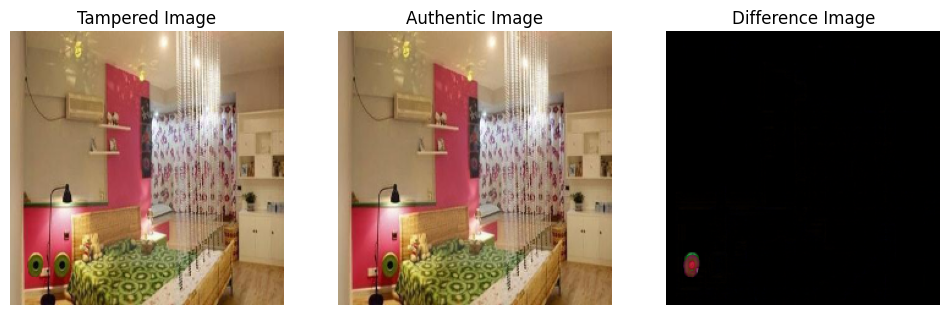

In [8]:
display_difference_example('D:\Studies\Mini prjt\CASIA2\Au', 'D:\Studies\Mini prjt\CASIA2\Tp')

In [13]:
# Load the base InceptionResNetV2 model, pre-trained on ImageNet, without the top layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add InceptionResNetV2 layers followed by custom dense layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification layer

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model with early stopping
epochs = 10
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=5)])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 55,124,193
Trainable params: 787,457
Non-t

In [14]:
# Save the entire model
model.save('InceptionResNetV2_BC.h5')
print("Saved model to disk.")

Saved model to disk.


Loaded the entire model from disk.
79/79 [==============================] - 207s 3s/step - loss: 0.0888 - accuracy: 0.9699
Final test loss: 0.08879558742046356, Final test accuracy: 0.9698771238327026
79/79 [==============================] - 204s 3s/step


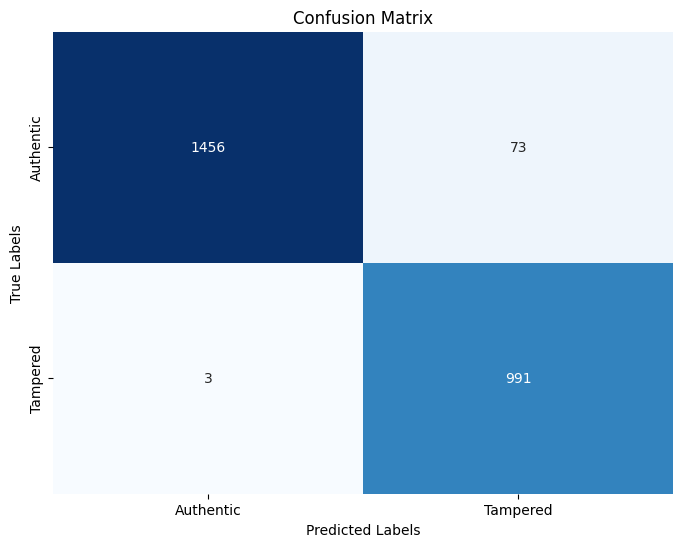

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1529
           1       0.93      1.00      0.96       994

    accuracy                           0.97      2523
   macro avg       0.96      0.97      0.97      2523
weighted avg       0.97      0.97      0.97      2523

F1 Score: 0.9630709426627793
Accuracy: 0.9698771304003171
precision: 0.931390977443609
recall: 0.9969818913480886


In [11]:
# Load the best model and evaluate
model = load_model('InceptionResNetV2_BC.h5')
print("Loaded the entire model from disk.")

# Evaluate the model
final_loss, final_accuracy = model.evaluate(X_test, y_test)
print(f"Final test loss: {final_loss}, Final test accuracy: {final_accuracy}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False, 
            xticklabels=['Authentic', 'Tampered'], 
            yticklabels=['Authentic', 'Tampered'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes))

# F1 Score
f1 = f1_score(y_test, y_pred_classes)
print(f"F1 Score: {f1}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy}")

# precision
precision = precision_score(y_test, y_pred_classes)
print(f"precision: {precision}")

# recall
recall = recall_score(y_test, y_pred_classes)
print(f"recall: {recall}")

In [16]:
def prepare_single_image(test_image_path, reference_image_path):
    # Load and resize the test image
    test_img = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
    test_img_resized = cv2.resize(test_img, (224, 224)).astype(np.float32) / 255.0

    # Load and resize the reference image
    reference_img = cv2.imread(reference_image_path, cv2.IMREAD_COLOR)
    reference_img_resized = cv2.resize(reference_img, (224, 224)).astype(np.float32) / 255.0

    # Calculate the difference image
    difference_img = calculate_difference_image(test_img_resized, reference_img_resized)
    difference_img = np.expand_dims(difference_img, axis=0)  # Expanding dimensions for the model
    return difference_img

In [17]:
model = load_model('InceptionResNetV2_BC.h5')
print("Loaded the entire model from disk.")

test_image_path = r'D:\Studies\Mini prjt\CASIA2\Tp\Tp_D_CNN_M_N_nat00089_nat00062_10577.jpg'
reference_image_path = r'D:\Studies\Mini prjt\CASIA2\Au\Au_nat_00089.jpg'

try:
    difference_image = prepare_single_image(test_image_path, reference_image_path)
    prediction = model.predict(difference_image)
    print(f"Prediction (0 for Authentic, 1 for Tampered): {prediction[0]}")
    if prediction[0] > 0.5:
        print("The image is likely tampered.")
    else:
        print("The image is likely authentic.")
except Exception as e:
    print(e)

Loaded the entire model from disk.
1/1 [==============================] - 2s 2s/step
Prediction (0 for Authentic, 1 for Tampered): [0.99999326]
The image is likely tampered.
